In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


In [14]:
metricas = pd.read_csv('metricasExpBH.csv')
metricas.head()

,Unnamed: 0,experimento,api,media,mediana,desvio_padrao,media_aparada,taxa_resposta,taxa_acerto
0,0,geoGoldBHexp1,MapBox,1.539552,0.000046,10.912322,0.511817,1.0000,0.8506
1,1,geoGoldBHexp1,Google,2.284151,0.008843,5.067888,1.541325,0.9992,0.7272
2,2,geoGoldBHexp1,TomTom,9.638626,0.097375,54.293889,2.383578,1.0000,0.5280
3,3,geoGoldBHexp1,OpenRouteService,5.443245,6.606720,4.669510,5.259343,0.9992,0.2646
4,4,geoGoldBHexp3,MapBox,1.985113,0.000046,12.479481,0.880777,1.0000,0.8246


In [15]:
substituicoes = {
    'geoGoldBHexp1': '1',
    'geoGoldBHexp3': '2',
    'geoGoldBHexp4': '2b',
    'geoGoldBHexp5': '3',
    'geoGoldBHexp6': '3b',
    'geoGoldBHexp7': '4',
    'geoGoldBHexp8': '4b',
    'geoGoldBHexp9': '5',
    'geoGoldBHexp10': '5b'
}

# Substituir os valores conforme o dicionário
metricas['experimento'] = metricas['experimento'].map(substituicoes).fillna(metricas['experimento'])

# Salvar o arquivo com as substituições
metricas.to_csv('metricas_atualizado.csv', index=False)

metricas.head()


,Unnamed: 0,experimento,api,media,mediana,desvio_padrao,media_aparada,taxa_resposta,taxa_acerto
0,0,1,MapBox,1.539552,0.000046,10.912322,0.511817,1.0000,0.8506
1,1,1,Google,2.284151,0.008843,5.067888,1.541325,0.9992,0.7272
2,2,1,TomTom,9.638626,0.097375,54.293889,2.383578,1.0000,0.5280
3,3,1,OpenRouteService,5.443245,6.606720,4.669510,5.259343,0.9992,0.2646
4,4,2,MapBox,1.985113,0.000046,12.479481,0.880777,1.0000,0.8246


In [16]:
def determinar_falha(erro):
    if erro <= 0.15:
        return 0.0
    else:
        return 1.0

In [17]:
shapefile_path = 'https://github.com/rcpsilva/UncertaintyQuantificationForGeocodingServices/raw/main/PaperGeoinfo/results/SMunicipios_2022/MG_Municipios_2022.shp'
gdf = gpd.read_file(shapefile_path)
city_name = "Belo Horizonte"  # Replace with the actual city name you want to plot
city_gdf = gdf[gdf['NM_MUN'] == city_name]

In [18]:
experimentos = pd.read_csv('geoGoldBHexpTotal.csv')
experimentos.head()

,SIGLA_TIPO_LOGRADOURO,NOME_LOGRADOURO,NUMERO_IMOVEL,NOME_BAIRRO_OFICIAL,LONGITUDE,LATITUDE,id,geoapi_id,request_id,lat,long,accuracy,endereço,erro,experimento
0,RUA,TRES,138,do Trevo,-19.830689,-44.016639,2852600,Google,2852600,-19.831190,-43.903133,NaN,"RUA TRES, 138, BELO HORIZONTE, MG",12.611892,1
1,RUA,TRES,138,do Trevo,-19.830689,-44.016639,2852600,OpenRouteService,2852600,-19.960829,-43.996589,1.000000,"RUA TRES, 138, BELO HORIZONTE, MG",10.671989,1
2,RUA,TRES,138,do Trevo,-19.830689,-44.016639,2852600,MapBox,2852600,-19.850858,-43.888999,1.000000,"RUA TRES, 138, BELO HORIZONTE, MG",14.274333,1
3,RUA,TRES,138,do Trevo,-19.830689,-44.016639,2852600,TomTom,2852600,-19.829050,-43.867790,11.958313,"RUA TRES, 138, BELO HORIZONTE, MG",16.539279,1
4,ROD,PRESIDENTE JUSCELINO KUBITSCHEK,1156,do Pilar,-20.002710,-43.965776,2852601,TomTom,2852601,-19.969140,-43.993180,14.742562,"RODOVIA PRESIDENTE JUSCELINO KUBITSCHEK, 1156,...",4.065210,1


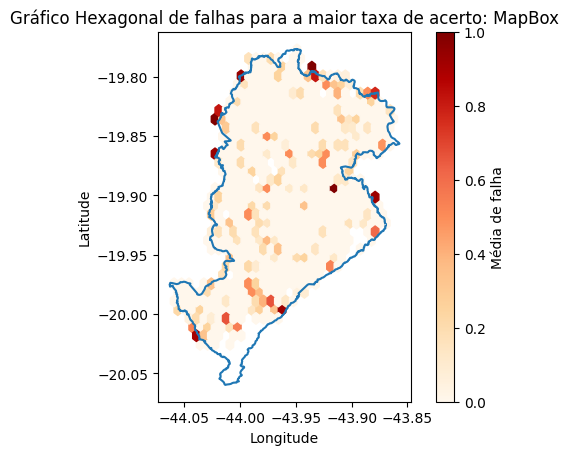

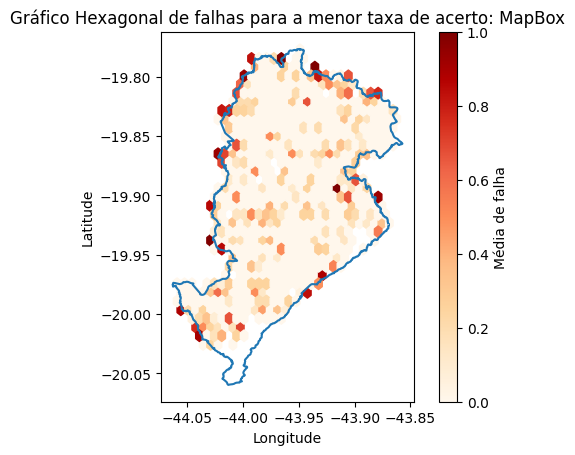

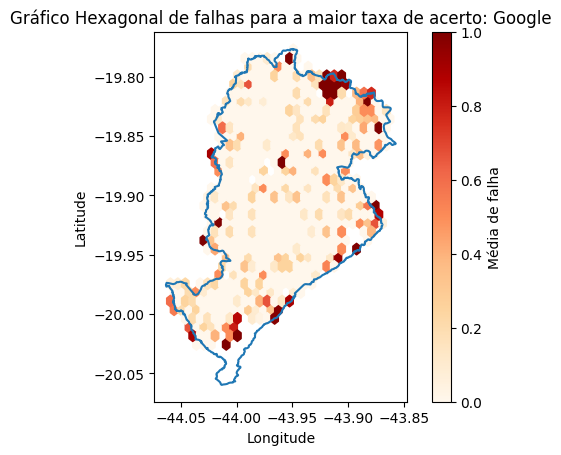

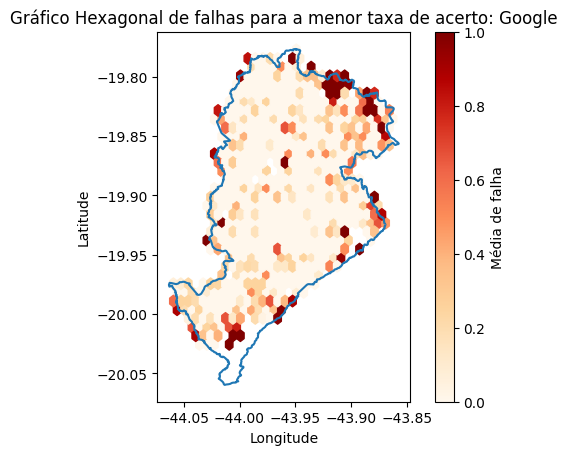

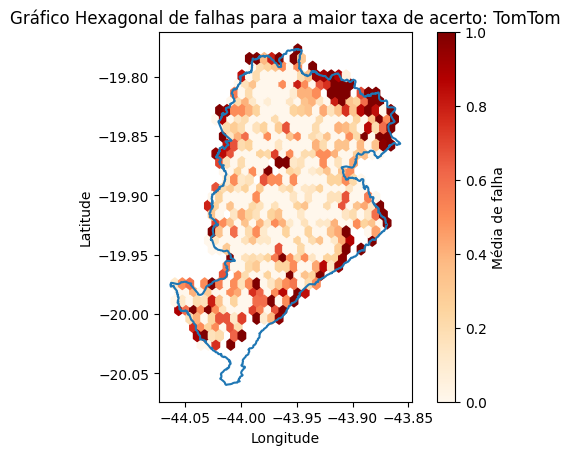

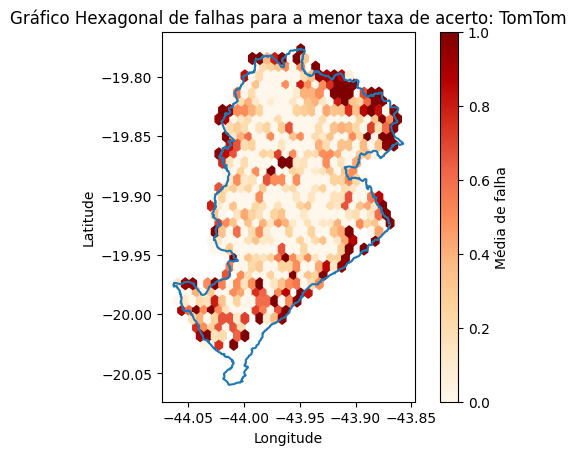

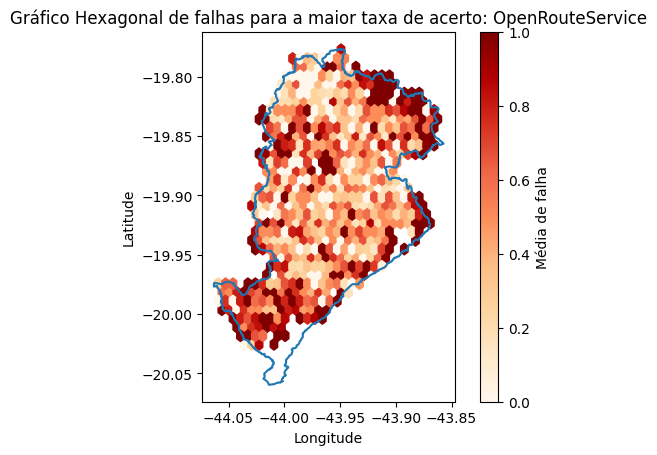

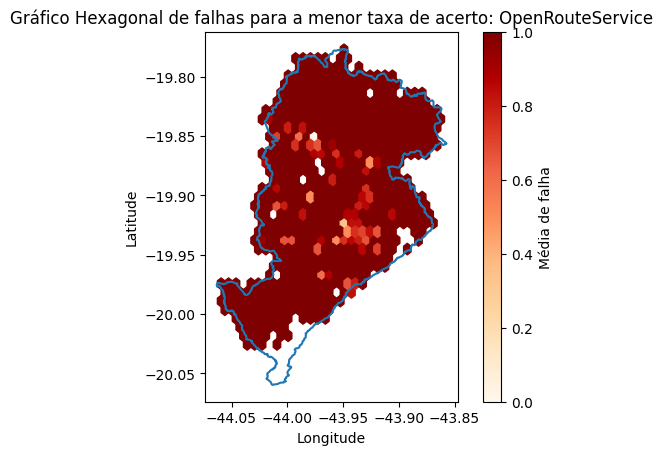

In [19]:
nome_apis = ['MapBox','Google', 'TomTom', 'OpenRouteService']
limite = 0.3
gridsize = 30

for api in nome_apis:
    filtro_api = metricas['api'] == api

    indice_max_taxa_acerto = metricas[filtro_api]['taxa_acerto'].idxmax()
    nome_arquivo_max = metricas.loc[indice_max_taxa_acerto, 'experimento']
    df_max = experimentos[experimentos['experimento'] == nome_arquivo_max]
    df_max = df_max[df_max['geoapi_id'] == api]
    #df = df[df['erro'] <= limite]
    falha =  df_max['erro'].apply(determinar_falha)
    df_max['falha'] = falha

    city_gdf.boundary.plot()
    hb = plt.hexbin(df_max['LATITUDE'], df_max['LONGITUDE'], C=df_max['falha'], gridsize=gridsize, cmap='OrRd',reduce_C_function=np.mean)
    cb = plt.colorbar()
    cb.set_label('Média de falha')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.title(f'Gráfico Hexagonal de falhas, com Erro Limitado em 300 metros: {api}')
    plt.title(f'Gráfico Hexagonal de falhas para a maior taxa de acerto: {api}')
    plt.clim(vmin=0, vmax=1)
    plt.show()

    
    indice_min_taxa_acerto = metricas[filtro_api]['taxa_acerto'].idxmin()
    nome_arquivo_min = metricas.loc[indice_min_taxa_acerto, 'experimento']
    df_min = experimentos[experimentos['experimento'] == nome_arquivo_min]
    df_min = df_min[df_min['geoapi_id'] == api]
    falha =  df_min['erro'].apply(determinar_falha)
    df_min['falha'] = falha
    
    city_gdf.boundary.plot()
    hb = plt.hexbin(df_min['LATITUDE'], df_min['LONGITUDE'], C=df_min['falha'], gridsize=gridsize, cmap='OrRd',reduce_C_function=np.mean)
    cb = plt.colorbar()
    cb.set_label('Média de falha')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.title(f'Gráfico Hexagonal de falhas, com Erro Limitado em 300 metros: {api}')
    plt.title(f'Gráfico Hexagonal de falhas para a menor taxa de acerto: {api}')
    plt.clim(vmin=0, vmax=1)
    plt.show()
    #print(df.head())
    